### TO DO
- Check the registration and if the aligment if correct in the spheres

### Env

In [1]:
import nibabel as nib
from nilearn import datasets, input_data, plotting, connectome, image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, zscore
import pandas as pd
import os
import json
import glob
import time
import gc
import time
import concurrent.futures
from joblib import Parallel, delayed


In [2]:
!hostname

beluga3.int.ets1.calculquebec.ca


In [3]:
os.cpu_count()

40

### Data

In [4]:
df_networks = pd.read_csv("mni_space_of_networks.csv")
df_networks.head()

,network,node number,x,y,z,name,description
0,AM,1,-1,-53,21,Autobiographical memory,A central domain involved in a core network li...
1,AM,2,-26,-28,-17,Autobiographical memory,A central domain involved in a core network li...
2,AM,3,-49,-61,31,Autobiographical memory,A central domain involved in a core network li...
3,AM,4,-2,51,-11,Autobiographical memory,A central domain involved in a core network li...
4,AM,5,-60,-9,-18,Autobiographical memory,A central domain involved in a core network li...


In [5]:
participants = pd.read_csv("ds002837-download/participants.tsv", sep='\t')
participants['sub'] = range(1,87)
participants = participants[participants['sub'] != 49] # ta corrompido
participants.head()

,participant_id,age,sex,task,sub
0,sub-1,23,M,500daysofsummer,1
1,sub-2,25,F,500daysofsummer,2
2,sub-3,23,M,500daysofsummer,3
3,sub-4,23,M,500daysofsummer,4
4,sub-5,22,F,500daysofsummer,5


In [6]:
len(participants)

85

### Functions

In [7]:
def load_image(sub, movie):
    path = os.path.join(f'/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-{sub}/func', 
                        f'sub-{sub}_task-{movie}_bold_blur_no_censor_ica.nii.gz')
    return nib.load(path, mmap=True)


def save_correlation_data(networks_data, sub, movie): 
    # format dataframe
    df = pd.DataFrame(networks_data, columns=['network', 'start', 'end', 
                                              'net_mean', 'net_median','net_std','net_mean_abs','net_median_abs','net_std_abs',
                                              'fc_mean_abs','fc_median_abs','fc_std_abs'])
    df['sub'] = sub
    df['movie'] = movie
    
    # file name
    base_filename = f'/home/tamires/projects/rpp-aevans-ab/tamires/networks_data/sub-{sub}_task-{movie}_networks'
    version = 1
    filename = f"{base_filename}_v{version}.parquet"
    
    # check if there is a previous version
    while os.path.exists(filename):
        version += 1
        filename = f"{base_filename}_v{version}.parquet"
    
    df.to_parquet(filename)

In [8]:
def brain_networks_extraction(df_networks, network_name, fmri_img, radius = 6):
    # Coordinates
    peak_coords = df_networks[df_networks.name == network_name][['x', 'y', 'z']].values
    # Create 6mm spheres around these coordinates
    spheres_masker = input_data.NiftiSpheresMasker(seeds=peak_coords, radius=radius, standardize=True)
    # Extract time series data for each sphere
    time_series = spheres_masker.fit_transform(fmri_img) 
    return time_series


def network_statistic(time_series):
    net_stats = [np.mean(time_series), 
                 np.median(time_series), 
                 np.std(time_series),
                 np.mean(abs(time_series)), 
                 np.median(abs(time_series)), 
                 np.std(abs(time_series))]
    return net_stats
    

def functional_conectivity_statistic(time_series):
    # Compute the functional connectome using ConnectivityMeasure
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    fc_stats = [np.mean(abs(correlation_matrix)), 
                np.median(abs(correlation_matrix)), 
                np.std(abs(correlation_matrix))]
    return fc_stats


def process_time_intervals(img_original, network_list, start, end, step, radius=2):
    """ Extract data of interval using brain_networks_extraction, network_statistic and functional_conectivity_statistic """
    
    networks_data = []
    for t in range(start, end, step):
        img = img_original.dataobj[:,:,:,t:t+step]
        img = nib.Nifti1Image(img, img_original.affine, img_original.header)
        
        for network_name in network_list:
            time_series = brain_networks_extraction(df_networks, network_name=network_name, fmri_img=img, radius=radius)
            net_stats = network_statistic(time_series)
            fc_stats = functional_conectivity_statistic(time_series)
            networks_data.append([network_name, t, t+step] + net_stats + fc_stats) 
            #print(f"{network_name} | clip start: {t} | clip end: {t+step}")
    
    return networks_data

### Run

##### Estimativa tempo

In [8]:
n_participants = 2
duracao_minutos = 5
n_networks = 2
step = 10

#####
segundos_totais = duracao_minutos*60
intervalos_totais = segundos_totais/step
tempo_process_de_intervalo = 2 * n_networks
estimativa_tempo_total_em_minutos = (n_participants * intervalos_totais * tempo_process_de_intervalo)/60

#####
segundos_totais, intervalos_totais, tempo_process_de_intervalo, estimativa_tempo_total_em_minutos

(300, 30.0, 4, 4.0)

In [15]:
n_participants = 20
n_networks = 2
step = 10

#####
segundos_totais = 10
intervalos_totais = segundos_totais/step
tempo_process_de_intervalo = 2 * n_networks
estimativa_tempo_total_em_minutos = (n_participants * intervalos_totais * tempo_process_de_intervalo)

#####
segundos_totais, intervalos_totais, tempo_process_de_intervalo, estimativa_tempo_total_em_minutos
# Rodou em 20s com 7 workers => 1/4 do tempo em serie

(10, 1.0, 4, 80.0)

In [22]:
n_participants = 20
n_networks = 14
step = 10

#####
segundos_totais = 10
intervalos_totais = segundos_totais/step
tempo_process_de_intervalo = 2 * n_networks
estimativa_tempo_total_em_minutos = (n_participants * intervalos_totais * tempo_process_de_intervalo)

#####
segundos_totais, intervalos_totais, tempo_process_de_intervalo, estimativa_tempo_total_em_minutos
# Rodou em 147s com 7 workers => 1/3 do tempo em serie

(10, 1.0, 28, 560.0)

##### Testes com menor escala possivel

In [10]:
%%time

sub = '2'
movie = '500daysofsummer'
print(f"Initializing processing participant {sub} | {movie}")

# Load: 153 ms
img_original = load_image(sub, movie)
print(f"Image loaded participant {sub} | {movie}")

# Process: 2s per interval per network
network_list = df_networks.name.unique()[:2]
networks_data = process_time_intervals(img_original, network_list, start = 0, end = 10, step = 10)
print(f"Networks processed participant {sub} | {movie}")

# Save: 600ms
save_correlation_data(networks_data, sub, movie)
print(f"File saved participant {sub} | {movie}")

Initializing processing participant 2 | 500daysofsummer
Image loaded participant 2 | 500daysofsummer
Networks processed participant 2 | 500daysofsummer
File saved participant 2 | 500daysofsummer
CPU times: user 6.16 s, sys: 447 ms, total: 6.6 s
Wall time: 4.66 s


##### Processando dados

In [12]:
img_original = load_image(sub = '16', movie = '500daysofsummer')

In [10]:
participants.iloc[15:20]

,participant_id,age,sex,task,sub
15,sub-16,50,F,500daysofsummer,16
16,sub-17,22,M,500daysofsummer,17
17,sub-18,53,M,500daysofsummer,18
18,sub-19,22,F,500daysofsummer,19
19,sub-20,43,M,500daysofsummer,20


In [ ]:
%%time

def process_participant(sub, movie, network_list, start, end, step):
    print(f"Initializing processing participant {sub} | {movie}")
    
    # Load: 153 ms
    img_original = load_image(sub, movie)
    
    # Process: 2s per interval per network
    networks_data = process_time_intervals(img_original, network_list, start=start, end=end, step=step)
    
    # Save: 600ms
    save_correlation_data(networks_data, sub, movie)
    print(f"File saved participant {sub} | {movie}")

# Parameters
participants_test = participants.iloc[15:20]
network_list = df_networks.name.unique()
end = img_original.shape[3] - (5 * 60) # final subtraido pela primeira rodada parquet v1
duration = 30 * 60
start = end - duration
step = 10

# Set the number of jobs (parallel workers)
n_jobs = 3  # Adjust this number based on your system's capacity

# Parallel processing using Joblib
os.environ["OMP_NUM_THREADS"] = "1"  # Ensure thread limiting if needed

# Use joblib.Parallel and joblib.delayed
results = Parallel(n_jobs=n_jobs)(
    delayed(process_participant)(sub, movie, network_list, start, end, step)
    for sub, movie in participants_test[['sub', 'task']].values
)

##### Arquivos corrompidos

In [16]:
#error = []
#for sub, movie in participants[['sub', 'task']].values:
#    path = os.path.join(f'/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-{sub}/func', 
                        f'sub-{sub}_task-{movie}_bold_blur_no_censor_ica.nii.gz')
#    print(path)
#    try:
#        img_original = nib.load(path, mmap=True)
#        print(img_original.shape)
#        error.append('no error')
#    except:
#        print(f'Error in {sub}')
#        error.append(f'Error {sub} who watch {movie}')
#        pass

Initializing processing participant 1 who watch 500daysofsummer
/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-1/func/sub-1_task-500daysofsummer_bold_blur_no_censor_ica.nii.gz
(64, 76, 64, 5470)
Initializing processing participant 2 who watch 500daysofsummer
/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-2/func/sub-2_task-500daysofsummer_bold_blur_no_censor_ica.nii.gz
(64, 76, 64, 5470)
Initializing processing participant 3 who watch 500daysofsummer
/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-3/func/sub-3_task-500daysofsummer_bold_blur_no_censor_ica.nii.gz
(64, 76, 64, 5470)
Initializing processing participant 4 who watch 500daysofsummer
/home/tamires/projects/rpp-aevans-ab/tamires/ds002837-download/derivatives/sub-4/func/sub-4_task-500daysofsummer_bold_blur_no_censor_ica.nii.gz
(64, 76, 64, 5470)
Initializing processing participant 5 who watch 500daysofsummer
/home/tamires/projects/rpp-a

In [19]:
#error

##### Graficos

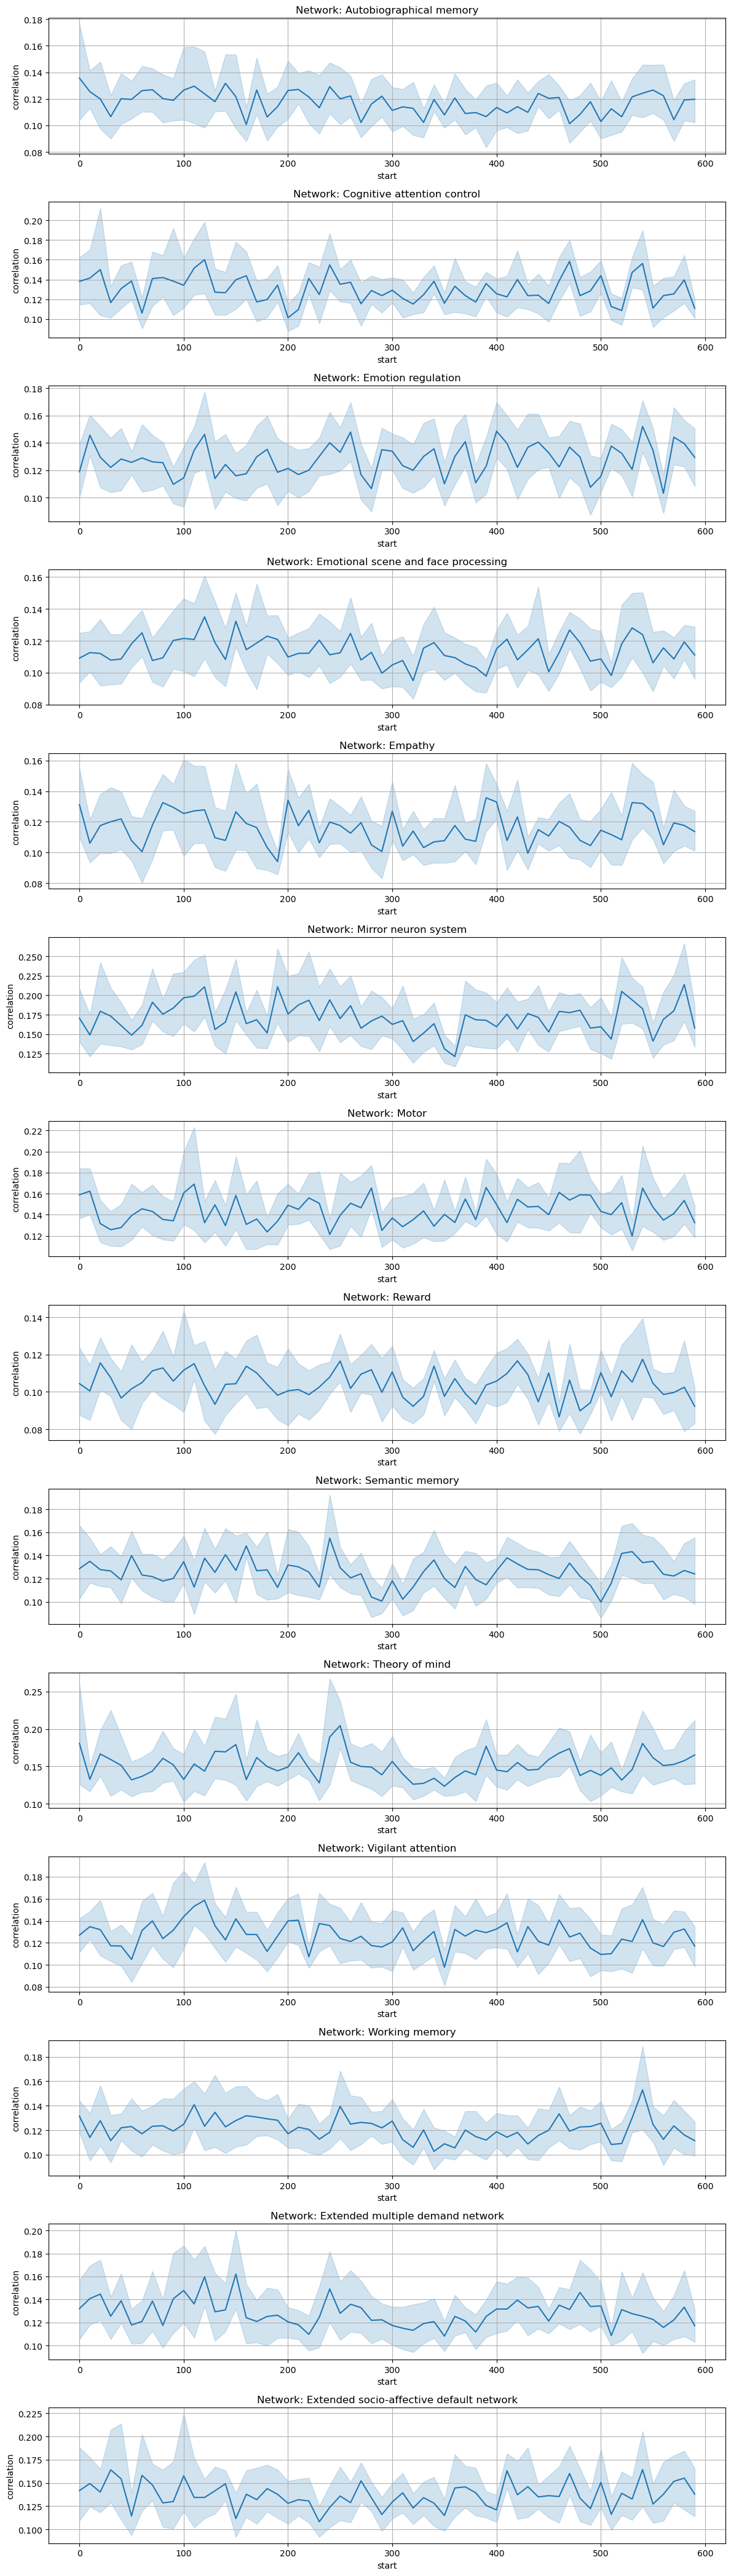

In [46]:
# Create subplots dynamically based on the number of unique networks
unique_networks = df_correlation.network.unique()
fig, axes = plt.subplots(len(unique_networks), 1, figsize=(12, 3 * len(unique_networks)))

# If there's only one network, wrap axes in a list to make it iterable
if len(unique_networks) == 1:
    axes = [axes]

# Loop through each network and plot
for ax, network in zip(axes, unique_networks):
    sns.lineplot(
        x='start', 
        y='correlation', 
        data=df_correlation[df_correlation.network == network], 
        errorbar='ci', 
        ax=ax, 
    )
    ax.set_title(f'Network: {network}')
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

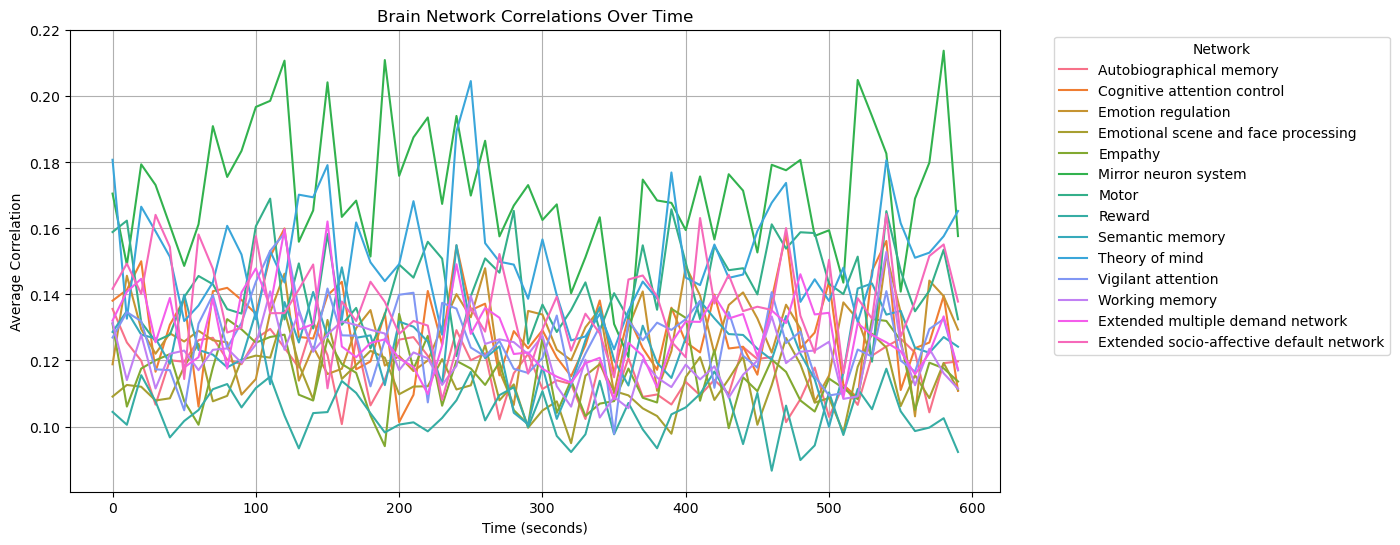

In [43]:
# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='start', y='correlation', hue='network', data=df_correlation, errorbar=None) 
plt.xlabel('Time (seconds)')
plt.ylabel('Average Correlation')
plt.title('Brain Network Correlations Over Time')
plt.legend(title='Network', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()